In [1]:

from filterpy.kalman import IMMEstimator, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt
from dynamicSystem import simulateNonlinearSSM
from threeTank import getThreeTankEquations, ThreeTank, parameter as param

from GP_BF import GP_SSM, GP_SSM2, init_GP_UKF

stateTransition, observation = getThreeTankEquations()

## optimal workflow

- for each Mode in IMM:
  - generate or load training Data
  - init gp state space model
  - train gaussian process
  - init bayes filter
- init interacting multiple model
- Test Loop

In [2]:
# init variables for IMM-GP-UKF

modeN = 2
stateN = 3
filters = []
models = []
mu = [0.5, 0.5]  # each filter is equally likely at the start
trans = np.array([[0.97, 0.03], [0.03, 0.97]])

dt = 1
z_std = 0.1

x = np.zeros(stateN) # initial state
P = 0.2 # initial uncertainty
R = np.diag([z_std**2, z_std**2, z_std**2]) # 1 standard
Q = Q_discrete_white_noise(dim=stateN, dt=dt, var=0.01**2, block_size=1) #TODO can also be standard noise of GP

# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(stateN, alpha=.1, beta=2., kappa=-1)

#TODO throw error when size of mu and trans does not match modeN

# create training data through simulation
xData, yData, dxData, tsData = simulateNonlinearSSM(ThreeTank(), x, dt, 100)

# init IMM with GP-UKF filters
for i in range(modeN):

    gpModel = GP_SSM2(dxData.transpose(), yData.transpose(), stateN)
    gpModel.optimize()
    models.append(gpModel)

    filter = init_GP_UKF(x, gpModel.stateTransition, observation, points, gpModel.stateTransitionVariance, P, R, Q, dt)
    filters.append(filter)

immUkf = IMMEstimator(filters, mu, trans)

Intializing with GP...
Fit Sparse GP...
Fit BGPLVM...
Done.
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0002   2.629415e+08   4.827272e+18 
    00s11  0008  -1.011477e+03   2.070650e+10 
    00s19  0023  -1.026415e+03   3.440340e+09 

 /home/alepp/miniconda3/envs/gpy/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



    03s24  0687  -1.498451e+03   1.208931e+10 
    04s47  1003  -1.543265e+03   3.296262e+09 
Runtime:     04s47
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s03  00001  -1.543265e+03   3.296367e+09 
    00s06  00005  -1.543500e+03   4.370591e+08 
    00s12  00012  -1.544186e+03   4.434160e+09 
    00s19  00020  -1.544918e+03   7.232262e+08 
    03s20  00532  -1.566147e+03   3.589430e+08 
    04s21  00705  -1.577133e+03   7.393229e+08 
    15s25  02276  -1.697802e+03   4.121809e+08 
    46s43  06687  -1.804947e+03   1.030568e+09 
    50s44  07317  -1.812261e+03   1.191874e+07 
 01m07s32  10002  -1.846643e+03   2.640289e+07 
Runtime:  01m07s32
Optimization status: Maximum number of f evaluations reached

Intializing with GP...
Fit Sparse GP...
Fit BGPLVM...
Done.
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0008  -

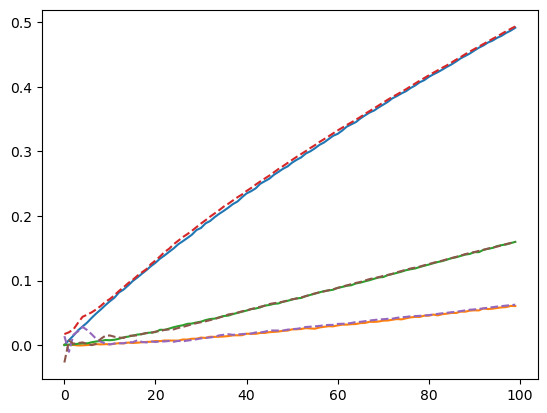

In [3]:
T = 100
x = np.zeros(stateN)

#zs = [[i+randn()*z_std, i+randn()*z_std] for i in range(T)]
xSim, ySim, dxSim, tSim = simulateNonlinearSSM(ThreeTank(param), x, dt, T)

zValues =  ySim
xValues = np.zeros((stateN,T))

for i in range(T):
    # perform predict/update cycle
    immUkf.predict()
    immUkf.update(zValues[:,i])

    xValues[:,i] = immUkf.x

    # xValues[0,i] = immUkf.x[0]
    # xValues[1,i] = immUkf.x[1]
    # xValues[2,i] = immUkf.x[2]

plt.figure()
plt.plot(zValues[0,:])
plt.plot(zValues[1,:])
plt.plot(zValues[2,:])

plt.plot(xValues[0,:],'--')
plt.plot(xValues[1,:],'--')
plt.plot(xValues[2,:],'--')

[0.26912307 0.02555932 0.0726767 ] [0.01973745 0.00035296 0.00236694]


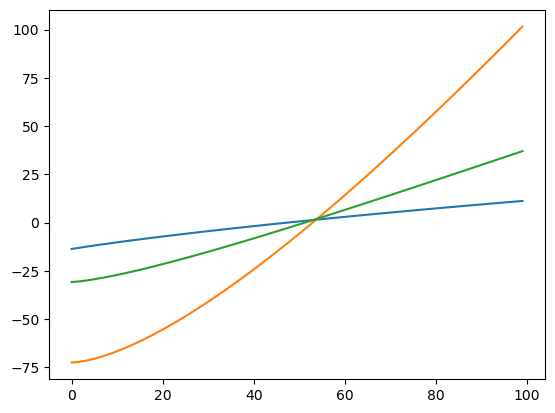

In [17]:
xData, yData, dxData, tsData = simulateNonlinearSSM(ThreeTank(), x, dt, 100)

xDataT = xData.copy().transpose()

mean = xDataT.mean(axis=0) 
std = xDataT.std(axis=0)
print(mean, std)

xNorm = (xDataT - mean) / std

plt.figure()
plt.plot(xNorm[:,0])
plt.plot(xNorm[:,1])
plt.plot(xNorm[:,2])